# Codeforces Problem Rating Predictor (Machine Learning Project)

This notebook outlines the steps for building a regression model to predict the difficulty rating of a Codeforces competitive programming problem based on its features, such as algorithmic tags, problem index, and number of successful submissions.

---

 Overview

In this project, we aim to build a machine learning model that predicts the difficulty rating of Codeforces problems.
To achieve this, our first step is to collect and prepare high-quality training data.

Codeforces provides a public REST API that exposes detailed information about all problems available on the platform. This includes:

Problem metadata
(contest ID, problem index such as A/B/C…, problem name, tags, points)

Problem statistics
(number of accepted submissions — useful as "solvedCount")

These two datasets complement each other, and merging them gives us a rich feature set to train our models.

## I. Data Acquisition and Preparation

This section handles connecting to the Codeforces API, fetching the problems data, merging problem details with statistics, and saving the raw datasets.

### Cell 1: Import Necessary Libraries

We import the fundamental libraries required for the project, including utilities for API calls, data handling, and the core ML components used throughout the notebook.

In [ ]:
import requests
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import MultiLabelBinarizer

### Cell 2: Create Data Storage Folder

A directory named `data` is created to store the fetched raw files and processed CSVs. `exist_ok=True` prevents errors if the folder already exists.

In [ ]:
os.makedirs("data", exist_ok=True)

### Cell 3: Fetch Data from Codeforces API

This cell calls the Codeforces `problemset.problems` API endpoint. It fetches two main lists: `problems` (containing ratings and tags) and `problemStatistics` (containing solved counts). A check ensures the API request was successful.

In [ ]:
# ============================================================
# STEP 1: LOAD CF DATA USING API
# ============================================================
url = "https://codeforces.com/api/problemset.problems"
resp = requests.get(url)
data = resp.json()

if data['status'] != 'OK':
    raise Exception("API request failed")

problems = data['result']['problems']
stats = data['result']['problemStatistics']

### Cells 4 & 5: Convert to DataFrame and Merge

Lists are converted to pandas DataFrames (`df_problems`, `df_stats`) and merged into a single master DataFrame (`df`) based on the unique problem identifiers: **`contestId`** and **`index`**.

In [ ]:
df_problems = pd.DataFrame(problems)
df_stats = pd.DataFrame(stats)

In [ ]:
df = pd.merge(df_problems, df_stats, on=['contestId', 'index'])

### Cell 6: Initial Data Inspection

Viewing the head confirms the successful merge. We can see that many problems lack a `rating` (NaN) and the `tags` column is stored as a list of strings.

In [ ]:
df.head(20)

,contestId,index,name,type,tags,rating,points,solvedCount
0,2172,N,New Kingdom,PROGRAMMING,[],NaN,NaN,35
1,2172,M,Maximum Distance To Port,PROGRAMMING,[],NaN,NaN,846
2,2172,L,Maximum Color Segment,PROGRAMMING,[dp],NaN,NaN,157
3,2172,K,Kindergarten Homework,PROGRAMMING,[],NaN,NaN,220
4,2172,J,Sliding Tiles,PROGRAMMING,[],NaN,NaN,147
5,2172,I,Birthday,PROGRAMMING,[geometry],NaN,NaN,290
6,2172,H,Shuffling Cards with Problem Solver 68!,PROGRAMMING,[string suffix structures],NaN,NaN,87
7,2172,G,Gene Editor,PROGRAMMING,[],NaN,NaN,4
8,2172,F,Cluster Computing System,PROGRAMMING,[],NaN,NaN,577
9,2172,E,Number Maze,PROGRAMMING,"[constructive algorithms, implementation]",NaN,NaN,1031


### Cell 7: Save Full Dataset

The complete dataset, including both rated and unrated problems, is saved to CSV for archival and easy reloading.

In [ ]:
df.to_csv("data/codeforces_problems_full.csv", index=False)
print("Saved full dataset to data/codeforces_problems_full.csv")

Saved full dataset to data/codeforces_problems_full.csv


### Cell 8: Filter and Save Rated Problems (Training Data)

Problems with missing `rating` values are dropped. The resulting `df_rated` is the **training dataset** for the model, as it contains our target variable.

In [ ]:
df_rated = df.dropna(subset=['rating'])
df_rated.to_csv("data/codeforces_problems_rated.csv", index=False)
print("Saved rated problems to data/codeforces_problems_rated.csv")

Saved rated problems to data/codeforces_problems_rated.csv


### Cell 9: Rated Data Head Check

We check the head of `df_rated` to ensure all rows now contain a non-NaN value in the `rating` column.

In [ ]:
df_rated.head(5)

,contestId,index,name,type,tags,rating,points,solvedCount
25,2167,G,Mukhammadali and the Smooth Array,PROGRAMMING,"[data structures, dp]",1600.0,NaN,8079
26,2167,F,"Tree, TREE!!!",PROGRAMMING,"[dfs and similar, dp, math, trees]",1600.0,NaN,4781
27,2167,E,khba Loves to Sleep!,PROGRAMMING,"[binary search, data structures, geometry, gre...",1600.0,NaN,6691
28,2167,D,Yet Another Array Problem,PROGRAMMING,"[brute force, implementation, math, number the...",1000.0,NaN,22915
29,2167,C,Isamatdin and His Magic Wand!,PROGRAMMING,"[constructive algorithms, greedy, implementati...",800.0,NaN,28832


### Cell 10: Filter and Save Unrated Problems

Problems with missing `rating` are isolated into `df_unrated`. This dataset is reserved for making final predictions.

In [ ]:
df_unrated = df[df['rating'].isna()]
df_unrated.to_csv("data/codeforces_problems_unrated.csv", index=False)
print("Saved unrated problems to data/codeforces_problems_unrated.csv")

Saved unrated problems to data/codeforces_problems_unrated.csv


### Cell 9: Unrated Data Head Check

We check the head of `df_unrated` to ensure all rows now contain a NaN value in the `rating` column.

In [ ]:
df_unrated.head(5)

,contestId,index,name,type,tags,rating,points,solvedCount
0,2172,N,New Kingdom,PROGRAMMING,[],NaN,NaN,35
1,2172,M,Maximum Distance To Port,PROGRAMMING,[],NaN,NaN,846
2,2172,L,Maximum Color Segment,PROGRAMMING,[dp],NaN,NaN,157
3,2172,K,Kindergarten Homework,PROGRAMMING,[],NaN,NaN,220
4,2172,J,Sliding Tiles,PROGRAMMING,[],NaN,NaN,147


### Cell 12 & 13: Unrated and Full Data Checks

Final confirmation that `df_unrated` only contains problems with `NaN` rating, and a check on the original `df`.

In [ ]:
df_unrated.head()

,contestId,index,name,type,tags,rating,points,solvedCount
0,2172,N,New Kingdom,PROGRAMMING,[],NaN,NaN,35
1,2172,M,Maximum Distance To Port,PROGRAMMING,[],NaN,NaN,846
2,2172,L,Maximum Color Segment,PROGRAMMING,[dp],NaN,NaN,157
3,2172,K,Kindergarten Homework,PROGRAMMING,[],NaN,NaN,220
4,2172,J,Sliding Tiles,PROGRAMMING,[],NaN,NaN,147


In [ ]:
df.head()

,contestId,index,name,type,tags,rating,points,solvedCount
0,2172,N,New Kingdom,PROGRAMMING,[],NaN,NaN,35
1,2172,M,Maximum Distance To Port,PROGRAMMING,[],NaN,NaN,846
2,2172,L,Maximum Color Segment,PROGRAMMING,[dp],NaN,NaN,157
3,2172,K,Kindergarten Homework,PROGRAMMING,[],NaN,NaN,220
4,2172,J,Sliding Tiles,PROGRAMMING,[],NaN,NaN,147


## II. Feature Engineering

This section loads the rated data and transforms categorical and text-based columns into a numeric format suitable for machine learning models.

### Cell 14: Load Rated Data for Processing 

We reload the `df_rated` to ensure we have a clean DataFrame before feature transformations begin. Note that the `tags` column may appear as a string representation of a list when loaded from CSV.

In [ ]:
df_rated = pd.read_csv("data/codeforces_problems_rated.csv")
df_rated.head()

,contestId,index,name,type,tags,rating,points,solvedCount
0,2167,G,Mukhammadali and the Smooth Array,PROGRAMMING,"['data structures', 'dp']",1600.0,NaN,8079
1,2167,F,"Tree, TREE!!!",PROGRAMMING,"['dfs and similar', 'dp', 'math', 'trees']",1600.0,NaN,4781
2,2167,E,khba Loves to Sleep!,PROGRAMMING,"['binary search', 'data structures', 'geometry...",1600.0,NaN,6691
3,2167,D,Yet Another Array Problem,PROGRAMMING,"['brute force', 'implementation', 'math', 'num...",1000.0,NaN,22915
4,2167,C,Isamatdin and His Magic Wand!,PROGRAMMING,"['constructive algorithms', 'greedy', 'impleme...",800.0,NaN,28832


### Cell 15: Transform Features (Tags & Index) 🛠️

This is the core feature engineering step:

1.  **Tags Parsing (Multi-Label):** A robust function (`parse_tags_string`) is defined and applied to convert the string list representations of tags into actual Python lists, which is necessary for multi-label processing.
2.  **One-Hot Encoding:** The **`MultiLabelBinarizer`** converts the tag lists into binary feature columns, where each unique tag becomes a feature (0/1).
3.  **Index Conversion:** The single-letter problem `index` (e.g., 'A', 'B', 'C') is converted into a numeric rank **`index_num`** (1, 2, 3...) to capture the difficulty curve within a contest.
4.  The original `tags` and intermediate `tags_list` columns are dropped.

Once we load the dataset containing all rated Codeforces problems, the next crucial step is feature engineering. This stage transforms raw textual and categorical problem attributes into structured, numerical features that can be used by machine learning models.

Feature engineering dramatically affects model performance, especially for problems like Codeforces difficulty prediction where metadata is rich but unstructured.

In [ ]:
# ============================================================
# STEP 2: FEATURE ENGINEERING
# - One-hot encode tags
# - Convert index (A, B, C, ...) to numeric
# ============================================================

def parse_tags_string(tags_str):
    if not isinstance(tags_str, str):
        return []
    content = tags_str.strip().strip('[]')
    if not content:
        return []
    return [t.strip() for t in content.split(",")]

df_rated["tags_list"] = df_rated["tags"].apply(parse_tags_string)

mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df_rated["tags_list"])
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_, index=df_rated.index)

df_rated = pd.concat([df_rated, tags_df], axis=1)
df_rated = df_rated.drop(columns=["tags", "tags_list"], errors="ignore")

df_rated["index_num"] = df_rated["index"].astype(str).str[0].str.upper().apply(lambda x: ord(x) - 64)


### Cell 16: Check Unique Tag Features

Displaying `mlb.classes_` confirms all unique tags extracted from the dataset are now the column headers for the one-hot encoded features.

In [ ]:
print(mlb.classes_)

["'*special'" "'2-sat'" "'binary search'" "'bitmasks'" "'brute force'"
 "'chinese remainder theorem'" "'combinatorics'"
 "'constructive algorithms'" "'data structures'" "'dfs and similar'"
 "'divide and conquer'" "'dp'" "'dsu'" "'expression parsing'" "'fft'"
 "'flows'" "'games'" "'geometry'" "'graph matchings'" "'graphs'"
 "'greedy'" "'hashing'" "'implementation'" "'interactive'" "'math'"
 "'matrices'" "'meet-in-the-middle'" "'number theory'" "'probabilities'"
 "'schedules'" "'shortest paths'" "'sortings'"
 "'string suffix structures'" "'strings'" "'ternary search'" "'trees'"
 "'two pointers'"]


### Cell 17: Check First Row's Final Feature Vector

Inspects the first row of the processed data to verify that `index_num` has been correctly computed and the tag columns contain `1` for present tags and `0` for absent tags.

In [ ]:
df_rated.head().iloc[0]

contestId                                                   2167
index                                                          G
name                           Mukhammadali and the Smooth Array
type                                                 PROGRAMMING
rating                                                    1600.0
points                                                       NaN
solvedCount                                                 8079
'*special'                                                     0
'2-sat'                                                        0
'binary search'                                                0
'bitmasks'                                                     0
'brute force'                                                  0
'chinese remainder theorem'                                    0
'combinatorics'                                                0
'constructive algorithms'                                      0
'data structures'        

## III. Model Training and Evaluation

This section prepares the final feature matrix $\mathbf{X}$ and target vector $\mathbf{y}$, splits the data, and trains several regression models to find the best predictor for the problem rating.

### Cell 18 & 19: Prepare Features (X) and Target (y)

1.  The `rating` column is isolated as the prediction target ($\mathbf{y}$).
2.  Non-numeric, non-feature columns (`index`, `name`, `type`) are dropped to create the feature matrix $\mathbf{X}$.
3.  The head of the final feature matrix $\mathbf{X}$ is displayed.

In [ ]:
# ============================================================
# Step 3: Prepare features and target
# ============================================================
X = df_rated.drop(columns=["index","name","rating","type"])
y = df_rated["rating"]

In [ ]:
X.head(5)

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
0,2167,NaN,8079,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,2167,NaN,4781,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,6
2,2167,NaN,6691,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,2167,NaN,22915,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
4,2167,NaN,28832,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3


### Cell 20: Split Dataset (Train / CV / Test)

The data is split into three subsets using two applications of `train_test_split` with `random_state=42` for reproducibility:

1.  **Train (60%):** Used for fitting models.
2.  **Cross-Validation (CV) (20%):** Used for hyperparameter tuning and model selection.
3.  **Test (20%):** Used for final, unbiased evaluation.

Any remaining NaN values (primarily in `points`) are imputed with `0` in all splits.

In [ ]:
# ============================================================
# STEP 4: TRAIN / CV / TEST SPLIT
# ============================================================

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

X_train = X_train.fillna(0)
X_cv = X_cv.fillna(0)
X_test = X_test.fillna(0)

print("Train set:", X_train.shape)
print("Cross-validation set:", X_cv.shape)
print("Test set:", X_test.shape)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()


Train set: (6303, 41)
Cross-validation set: (2102, 41)
Test set: (2102, 41)


### Cells 25-27: Inspect Data Splits

Verify the heads of the split feature datasets ($X_{\text{train}}, X_{\text{cv}}, X_{\text{test}}$) to confirm they align with the expected feature set.

In [ ]:
X_train.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
1006,2001,1500.0,12306,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,3
8582,455,1500.0,6209,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,3
3472,1571,0.0,64,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2601,1735,1250.0,10687,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
10334,37,1000.0,1040,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
X_cv.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
8243,540,1500.0,7969,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1198,1974,0.0,10355,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9178,294,500.0,26392,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10184,62,2000.0,411,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5988,1057,1000.0,1916,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
X_test.head()

,contestId,points,solvedCount,'*special','2-sat','binary search','bitmasks','brute force','chinese remainder theorem','combinatorics',...,'probabilities','schedules','shortest paths','sortings','string suffix structures','strings','ternary search','trees','two pointers',index_num
8985,343,500.0,9763,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
565,2066,2000.0,356,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5173,1220,1000.0,12011,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3884,1491,1000.0,8277,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
7823,638,2000.0,750,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4


### Cell 28: Model Comparison and Selection

This crucial cell runs the machine learning pipeline:

1.  **Utilities:** Helper functions like `round_to_nearest_100` are defined to handle Codeforces' 100-point rating steps.
2.  **Training & Tuning:** Multiple models (Linear, Ridge, Polynomial, Decision Tree, Random Forest, and XGBoost) are trained and tuned using **`GridSearchCV`** on the **training set**.
3.  **Cross-Validation Evaluation:** Models are evaluated on the **CV set**. The best model is selected based on the lowest **RMSE on rounded predictions**.
4.  **Final Test Evaluation:** The best model (**XGBoostRegressor**) is retrained on the combined Train+CV set and evaluated on the reserved **Test Set** to get the final, unbiased performance metrics.

In [ ]:
# ============================================================
# STEP 4: FULL MODEL TRAINING (ALL MODELS INCLUDED)
# ============================================================

import warnings, time
warnings.filterwarnings("ignore")

from pathlib import Path
import joblib

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# XGBoost Auto-install
try:
    from xgboost import XGBRegressor
    XGB_PRESENT = True
except ImportError:
    import subprocess, sys
    print("Installing XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    from xgboost import XGBRegressor
    XGB_PRESENT = True

Path("models").mkdir(exist_ok=True)

def round_to_100(preds):
    a = np.array(preds)
    return ((a + 50) // 100 * 100)

def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))

def eval_metrics(y_true, y_pred):
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)

    rmse_raw = rmse(y_true_arr, y_pred_arr)
    pred_rounded = round_to_100(y_pred_arr)
    rmse_rounded = rmse(y_true_arr, pred_rounded)
    rmse_hundreds = rmse_rounded / 100.0
    mae_steps = np.mean(np.abs(pred_rounded - y_true_arr) / 100.0)
    exact_match = np.mean(pred_rounded == y_true_arr)
    within_one_step = np.mean(np.abs(pred_rounded - y_true_arr) <= 100)

    return {
        "rmse_raw": float(rmse_raw),
        "rmse_rounded": float(rmse_rounded),
        "rmse_hundreds": float(rmse_hundreds),
        "mae_steps": float(mae_steps),
        "exact_match": float(exact_match),
        "within_±1_step": float(within_one_step)
    }


kf = KFold(n_splits=5, shuffle=True, random_state=42)
models_info = []

def save_model(name, est):
    est.fit(X_train, y_train)
    joblib.dump(est, f"models/{name}.joblib")

print("\n==============================")
print(" TRAINING ALL MODELS")
print("==============================\n")


# ----------------------------------
# Linear Regression
# ----------------------------------
print("▶ Linear Regression STARTED")
t0 = time.time()

lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
preds = cross_val_predict(lr, X_train, y_train, cv=kf)
lr.fit(X_train.fillna(0), y_train)
joblib.dump(lr, "models/LinearRegression.joblib")
models_info.append({"name":"LinearRegression","est":lr, **eval_metrics(y_train,preds)})


print(f"✔ Linear Regression DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# Ridge Regression
# ----------------------------------
print("▶ Ridge Regression STARTED")
t0 = time.time()

ridge = GridSearchCV(
    Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())]),
    {"ridge__alpha":[0.1,1,10]},
    cv=3,
    scoring="neg_mean_squared_error"
)
preds = cross_val_predict(ridge, X_train, y_train, cv=kf)
ridge.fit(X_train, y_train)
best_ridge = ridge.best_estimator_
joblib.dump(best_ridge, "models/Ridge.joblib")

models_info.append({
    "name":"Ridge",
    "est":best_ridge,
    **eval_metrics(y_train, preds)
})


print(f"✔ Ridge Regression DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# Polynomial Regression (Deg 2 & 3)
# ----------------------------------
for deg in (2,3):
    print(f"▶ Polynomial Regression DEG {deg} STARTED")
    t0 = time.time()

    poly = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])
    preds = cross_val_predict(poly, X_train[numeric_cols], y_train, cv=kf)

    models_info.append({
        "name":f"Polynomial_deg{deg}",
        "est":poly,
        "poly":True,
        **eval_metrics(y_train,preds)
    })
    poly.fit(X_train[numeric_cols], y_train)
    joblib.dump(poly, f"models/Polynomial_deg{deg}.joblib")


    print(f"✔ Polynomial Regression DEG {deg} DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# Decision Tree
# ----------------------------------
print("▶ Decision Tree STARTED")
t0 = time.time()

dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    {"max_depth":[5,10,20,None]},
    cv=3,
    scoring="neg_mean_squared_error"
)
preds = cross_val_predict(dt, X_train, y_train, cv=kf)
dt.fit(X_train, y_train)
best_dt = dt.best_estimator_
joblib.dump(best_dt, "models/DecisionTree.joblib")
models_info.append({"name":"DecisionTree","est":best_dt, **eval_metrics(y_train,preds)})


print(f"✔ Decision Tree DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# Random Forest
# ----------------------------------
print("▶ Random Forest STARTED")
t0 = time.time()

rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    {"n_estimators":[50,100],"max_depth":[10,20,None]},
    cv=3,
    scoring="neg_mean_squared_error"
)
preds = cross_val_predict(rf, X_train, y_train, cv=kf)
rf.fit(X_train, y_train)
best_rf = rf.best_estimator_
joblib.dump(best_rf, "models/RandomForest.joblib")

models_info.append({
    "name":"RandomForest",
    "est":best_rf,
    **eval_metrics(y_train, preds)
})

print(f"✔ Random Forest DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# KNN Regression
# ----------------------------------
print("▶ KNN Regression STARTED")
t0 = time.time()

knn = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor())])
preds = cross_val_predict(knn, X_train, y_train, cv=kf)
models_info.append({"name":"KNNRegressor","est":knn,**eval_metrics(y_train,preds)})
knn.fit(X_train, y_train)
joblib.dump(knn, "models/KNNRegressor.joblib")


print(f"✔ KNN Regression DONE in {time.time()-t0:.2f} sec\n")


# # ----------------------------------
# # Gaussian Process Regressor
# # ----------------------------------
# print("▶ Gaussian Process Regressor STARTED ")
# t0 = time.time()

# # Train on a small subset (GPR is extremely slow)
# sample_idx = X_train.sample(n=2000, random_state=42).index

# gpr = GaussianProcessRegressor(kernel=RBF())

# # Fit on numeric subset only
# gpr.fit(X_train.loc[sample_idx, numeric_cols], y_train.loc[sample_idx])

# # Predict on the SAME subset (for fair metrics)
# preds = gpr.predict(X_train.loc[sample_idx, numeric_cols])

# # Save the GPR model
# joblib.dump(gpr, "models/GaussianProcessRegressor.joblib")

# # Store metrics
# models_info.append({
#     "name": "GaussianProcessRegressor",
#     "est": gpr,
#     "poly": True,
#     **eval_metrics(y_train.loc[sample_idx], preds)
# })

# print(f"✔ Gaussian Process DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# XGBoost
# ----------------------------------
if XGB_PRESENT:
    print("▶ XGBoost STARTED")
    t0 = time.time()

    xgb = GridSearchCV(
        XGBRegressor(objective="reg:squarederror"),
        {"n_estimators":[50,100],"max_depth":[3,6]},
        cv=3,
        scoring="neg_mean_squared_error"
    )
    preds = cross_val_predict(xgb, X_train, y_train, cv=kf)
    xgb.fit(X_train, y_train)
    best_xgb = xgb.best_estimator_
    joblib.dump(best_xgb, "models/XGBoost.joblib")

    models_info.append({
        "name":"XGBoost",
        "est":best_xgb,
        **eval_metrics(y_train, preds)
    })


    print(f"✔ XGBoost DONE in {time.time()-t0:.2f} sec\n")


# ----------------------------------
# Select Best Model
# ----------------------------------
print("▶ Selecting BEST MODEL...")

summary = pd.DataFrame(models_info)

best_row = summary.sort_values("rmse_rounded").iloc[0]

best_name = best_row["name"]
best_est  = best_row["est"]

display(summary[[
    "name",
    "rmse_raw",
    "rmse_rounded",
    "rmse_hundreds",
    "mae_steps",
    "exact_match",
    "within_±1_step"
]])
print("\nBest model selected:", best_name)

X_traincv = pd.concat([X_train, X_cv])
y_traincv = pd.concat([y_train, y_cv])

if best_row.get("poly", False):
    best_est.fit(X_traincv[numeric_cols], y_traincv)
else:
    best_est.fit(X_traincv, y_traincv)

joblib.dump(best_est, f"models/best_model_{best_name}.joblib")
joblib.dump(best_est, "models/best_model.joblib")

print("\n BEST MODEL:", best_name)
print("Training & Validation Completed Successfully!")



 TRAINING ALL MODELS

▶ Linear Regression STARTED
✔ Linear Regression DONE in 0.24 sec

▶ Ridge Regression STARTED
✔ Ridge Regression DONE in 0.52 sec

▶ Polynomial Regression DEG 2 STARTED
✔ Polynomial Regression DEG 2 DONE in 8.03 sec

▶ Polynomial Regression DEG 3 STARTED


In [ ]:
import joblib, json

joblib.dump(best_est, "models/best_model.joblib")
json.dump(list(X_train.columns), open("models/feature_names.json", "w"))
json.dump(numeric_cols, open("models/numeric_cols.json", "w"))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df["rating"], bins=30, kde=True)
plt.title("Rating Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["solvedCount"], bins=40, kde=True)
plt.title("Solved Count Distribution")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(df["solvedCount"], df["rating"], alpha=0.4)
plt.title("SolvedCount vs Rating")
plt.show()

plt.figure(figsize=(16,10))
corr = df.select_dtypes(include=["number"]).corr()
sns.heatmap(corr, cmap="coolwarm")
plt.show()


ModuleNotFoundError: No module named 'matplotlib'

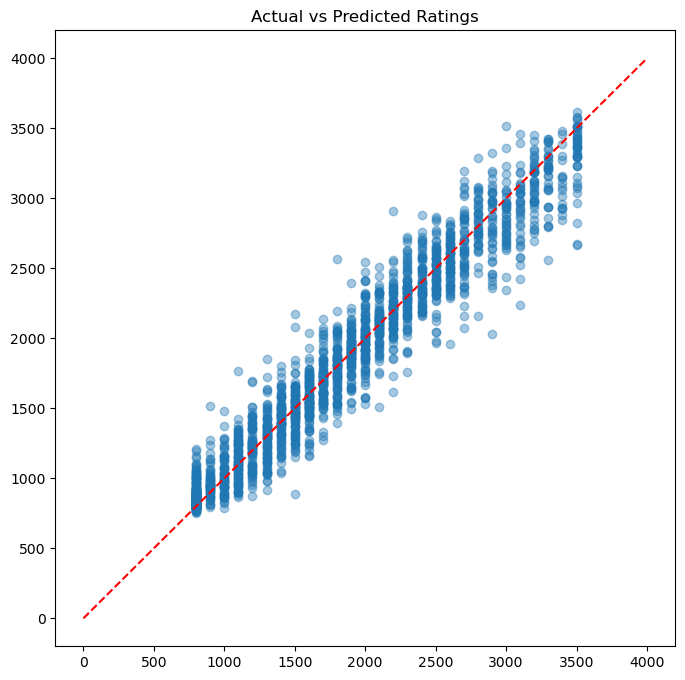

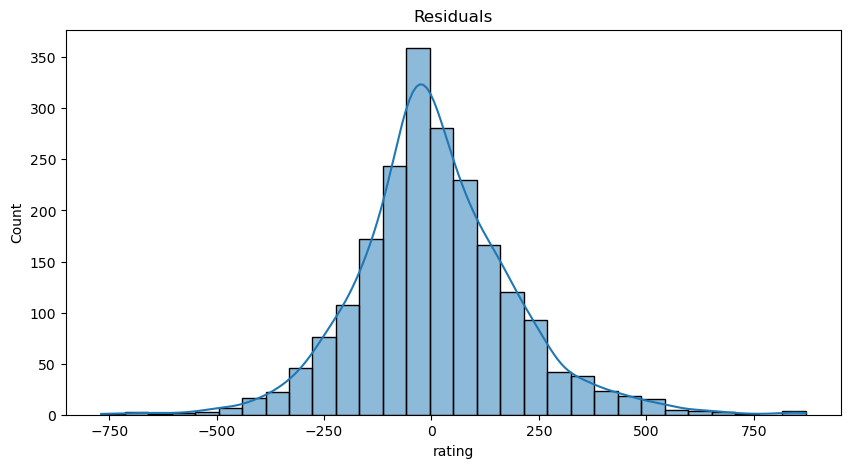

In [ ]:
if "poly" in summary.iloc[0]:
    X_test_in = X_test[numeric_cols]
else:
    X_test_in = X_test

y_pred = best_est.predict(X_test_in)

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,4000],[0,4000],'r--')
plt.title("Actual vs Predicted Ratings")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals")
plt.show()


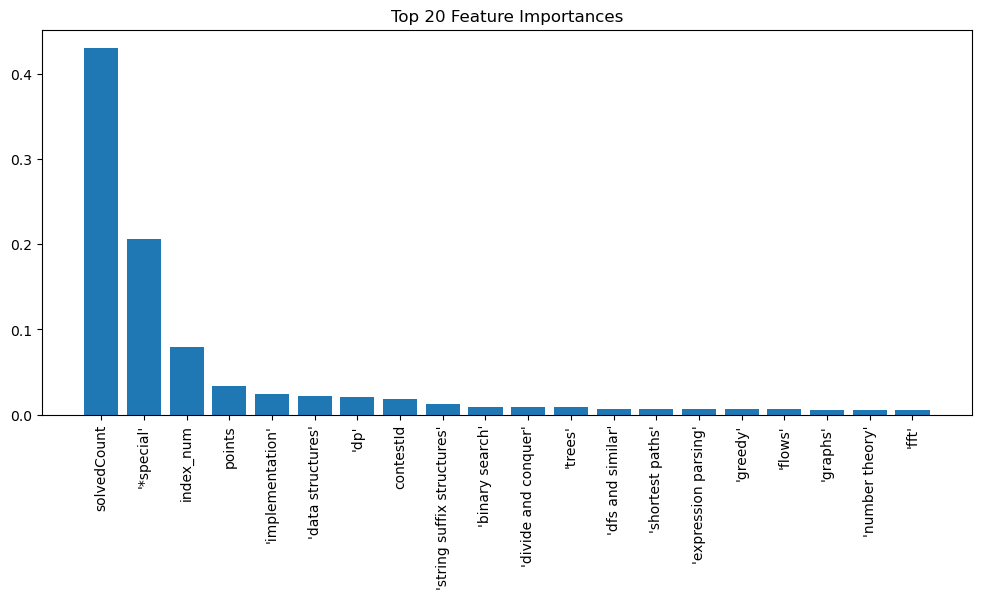

In [ ]:
if hasattr(best_est, "feature_importances_"):
    imp = best_est.feature_importances_
    idx = np.argsort(imp)[::-1][:20]

    plt.figure(figsize=(12,5))
    plt.bar(range(20), imp[idx])
    plt.xticks(range(20), X_train.columns[idx], rotation=90)
    plt.title("Top 20 Feature Importances")
    plt.show()
else:
    print("Best model has no feature_importances_")


## IV. Prediction on Unrated Problem

This section demonstrates how to use the final selected model to predict the rating of a specific, unrated Codeforces problem.

In [ ]:
# ============================================================
# PREDICT RATING FOR ANY PROBLEM USING ALL MODELS + BEST MODEL
# ============================================================

import requests
import re
import numpy as np
import pandas as pd

def fetch_problem_from_api(contestId=None, index=None, url=None):
    api_url = "https://codeforces.com/api/problemset.problems"
    resp = requests.get(api_url)
    resp.raise_for_status()
    data = resp.json()
    if data.get("status") != "OK":
        raise RuntimeError("Codeforces API error")
    problems = data["result"]["problems"]

    if url:
        m = re.search(r'/contest/(\d+)/problem/([A-Za-z0-9]+)', url)
        if not m:
            m = re.search(r'/problemset/problem/(\d+)/([A-Za-z0-9]+)', url)
        if m:
            contestId = int(m.group(1))
            index = m.group(2)

    if contestId is not None and index is not None:
        for p in problems:
            if str(p.get("contestId")) == str(contestId) and str(p.get("index")).upper() == str(index).upper():
                return p
        raise ValueError(f"Problem {contestId}-{index} not found.")
    return None


def sample_unrated_problem_from_csv(csv_path="data/codeforces_problems_unrated.csv"):
    df_unrated = pd.read_csv(csv_path)
    row = df_unrated.sample(1).iloc[0].to_dict()
    if isinstance(row.get("tags"), str):
        row["tags"] = [t.strip() for t in row["tags"].split(",") if t.strip()]
    return row


def build_feature_vector(problem, X_columns, numeric_cols):
    feat = {c: 0 for c in X_columns}

    if problem.get("contestId"):
        feat["contestId"] = int(problem["contestId"])

    idx = problem.get("index")
    if isinstance(idx, str):
        feat["index_num"] = ord(idx[0].upper()) - 64

    points = problem.get("points")
    if points:
        try:
            feat["points"] = float(points)
        except:
            feat["points"] = 0.0

    tags = problem.get("tags", [])
    if isinstance(tags, str):
        tags = [t.strip() for t in tags.split(",") if t.strip()]

    for tag in tags:
        tag_clean = tag.strip("' ")
        if tag_clean in feat:
            feat[tag_clean] = 1
        if f"'{tag_clean}'" in feat:
            feat[f"'{tag_clean}'"] = 1

    row_df = pd.DataFrame([feat], columns=X_columns).fillna(0)
    return row_df


def predict_with_models_on_row(row_df, models_info, numeric_cols):
    out = []
    for info in models_info:
        name = info["name"]
        est = info["est"]       

        if name.startswith("Polynomial"):
            X_in = row_df[numeric_cols].fillna(0)
        else:
            X_in = row_df.fillna(0)

        pred_raw = est.predict(X_in)[0]
        pred_rounded = int(((pred_raw + 50) // 100) * 100)

        out.append({
            "model": name,
            "pred_raw": float(pred_raw),
            "pred_rounded": pred_rounded
        })
    return out


# --------------------------
# 1) Choose a problem
# --------------------------
contestId_input = 2156
index_input = "A"
problem_url = "https://codeforces.com/contest/2156/problem/A"

try:
    prob = fetch_problem_from_api(contestId_input, index_input, problem_url)
    print(f"Fetched: {prob['contestId']} {prob['index']} - {prob['name']}")
except Exception:
    print("API failed → picking a random unrated problem")
    prob = sample_unrated_problem_from_csv()


# --------------------------
# 2) Build the feature vector
# --------------------------
X_columns = X_train.columns.tolist()
row_feat = build_feature_vector(prob, X_columns, numeric_cols)

print("\nFeature vector (non-zero values):")
display(row_feat.loc[:, (row_feat != 0).any(axis=0)])


# --------------------------
# 3) Predict using ALL models
# --------------------------
preds = predict_with_models_on_row(row_feat, models_info, numeric_cols)
preds_df = pd.DataFrame(preds).sort_values("pred_rounded").reset_index(drop=True)

print("\nPredictions from ALL models:")
display(preds_df)


# --------------------------
# 4) Predict using BEST MODEL
# --------------------------
try:
    best_name_local = best_name
    if best_name_local.startswith("Polynomial"):
        X_in = row_feat[numeric_cols]
    else:
        X_in = row_feat

    best_raw = best_est.predict(X_in)[0]
    best_rounded = int(((best_raw + 50) // 100) * 100)

    print(f"\nBest model: {best_name_local}")
    print(f"  raw = {best_raw:.2f}")
    print(f"  rounded = {best_rounded}")

except Exception as e:
    print("Best model prediction failed:", e)


# --------------------------
# 5) Save outputs
# --------------------------
row_feat.to_csv("models/last_unrated_problem_features.csv", index=False)
preds_df.to_csv("models/last_unrated_problem_predictions.csv", index=False)

print("\nSaved feature vector & predictions.")


Fetched: 2156 A - Pizza Time

Feature vector (non-zero values):


,contestId,points,'brute force','constructive algorithms','greedy',index_num
0,2156,500.0,1,1,1,1



Predictions from ALL models:


,model,pred_raw,pred_rounded
0,LinearRegression,1375.339629,1400
1,Ridge,1375.669932,1400
2,Polynomial_deg3,1538.557792,1500
3,Polynomial_deg2,1704.641009,1700
4,KNNRegressor,1980.000000,2000
5,XGBoost,3176.136475,3200
6,RandomForest,3392.000000,3400
7,DecisionTree,3468.253968,3500



Best model: XGBoost
  raw = 3176.14
  rounded = 3200

Saved feature vector & predictions.
